# Induction

This is a simple demonstration of path patching to find induction heads in GPT-2 Small.

(See [*In-context Learning and Induction Heads*](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html) for more on induction heads.)

We'll start by loading the model, wrapping it with the path patching helper code, and tokenising our two inputs. Our two sentences are:

1. I am from the state of New York. New York
2. I am from the state of New Jersey. New York

The first one should strongly trigger induction, i.e. at the second "\_New" we should get a high probability for "\_York". The second one should instead trigger induction for "\_Jersey". By patching in activations from the second sentence into the model running on the first, we can see which attention heads are involved in induction. A patch which strongly increases the probability of "\_Jersey" indicates we have found an induction head.

In [1]:
import gpt2

config, tokenizer, gpt = gpt2.create_gpt2()
model = gpt2.GPT2(config, gpt, verbose=False)

/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inputs = [
    tokenizer("I am from the state of New York. New York", return_tensors="pt"),
    tokenizer("I am from the state of New Jersey. New York", return_tensors="pt")
]

Some helpers. The model outputs the final hidden state, which we need to project into a distribution over the vocabular using the transpose of the embedding matrix, and then take softmax.

In [3]:
import torch

sm = torch.nn.Softmax(dim=2)

def embed_to_distrib(model, embed):
    with torch.inference_mode():
        vocab = torch.matmul(embed, model.model.wte.weight.t())
        return sm(vocab)

def top_vals(tokenizer, res, n=10):
    top_values, top_indices = torch.topk(res, n)
    print(f"{'Index':<20} Value")
    for i in range(len(top_values)):
        tok = tokenizer.decode(top_indices[i].item()).replace(" ", "_").replace("\n", "\\n")
        print(f"{tok:<20} {top_values[i].item()}")

Now we run the path patching and collect probabilities for "\_York" and "\_Jersey" at the position we care about.

In [6]:
p_York, p_Jersey = {}, {}
for layer in range(config.n_layer):
    for head in range(config.n_head):
        
        # when to branch: the attn at the layer of this head
        def branch(path):
            if path[-1] == f"a{layer}": return True
            if path[-1] == f"a{layer}.head": return True
            return False
        
        def which(path):
            if f"a{layer}.head{head}" in path: return 1
            return 0
        
        res = model(inputs, which, branch).hidden_states
        distrib = embed_to_distrib(model, res)[0][9]
        p_York[(layer, head)] = distrib[tokenizer.encode(" York")[0]]
        p_Jersey[(layer, head)] = distrib[tokenizer.encode(" Jersey")[0]]
        print(f"\nLayer {layer}, Head {head}")
        top_vals(tokenizer, distrib, n=2)
    
    def branch(path):
        if path[-1] == f"f{layer}": return True
        return False
    
    def which(path):
        if f"f{layer}" in path: return 1
        return 0
    
    res = model(inputs, which, branch).hidden_states
    distrib = embed_to_distrib(model, res)[0][9]
    p_York[(layer, config.n_head)] = distrib[tokenizer.encode(" York")[0]]
    p_Jersey[(layer, config.n_head)] = distrib[tokenizer.encode(" Jersey")[0]]
    print(f"\nLayer {layer}, Head {head}")
    top_vals(tokenizer, distrib, n=2)


Layer 0, Head 0
Index                Value
_York                0.8523692488670349
_Yorkers             0.06456416100263596

Layer 0, Head 1
Index                Value
_York                0.8514811992645264
_Yorkers             0.063127800822258

Layer 0, Head 2
Index                Value
_York                0.8527571558952332
_Yorkers             0.06516562402248383

Layer 0, Head 3
Index                Value
_York                0.847131609916687
_Yorkers             0.06402023881673813

Layer 0, Head 4
Index                Value
_York                0.8560593724250793
_Yorkers             0.06305011361837387

Layer 0, Head 5
Index                Value
_York                0.8400207757949829
_Yorkers             0.06420446187257767

Layer 0, Head 6
Index                Value
_York                0.8483042120933533
_Yorkers             0.06596900522708893

Layer 0, Head 7
Index                Value
_York                0.8527244925498962
_Yorkers             0.06629972904920578

La


Layer 5, Head 3
Index                Value
_York                0.8511543869972229
_Yorkers             0.06502602249383926

Layer 5, Head 4
Index                Value
_York                0.8508554697036743
_Yorkers             0.06518545001745224

Layer 5, Head 5
Index                Value
_York                0.8608907461166382
_Yorkers             0.06162277236580849

Layer 5, Head 6
Index                Value
_York                0.8509147763252258
_Yorkers             0.06497028470039368

Layer 5, Head 7
Index                Value
_York                0.8528473377227783
_Yorkers             0.06356015056371689

Layer 5, Head 8
Index                Value
_York                0.8443319797515869
_Yorkers             0.06877445429563522

Layer 5, Head 9
Index                Value
_York                0.8499428033828735
_Yorkers             0.06521384418010712

Layer 5, Head 10
Index                Value
_York                0.8483749628067017
_Yorkers             0.06717213988304138


Layer 10, Head 6
Index                Value
_York                0.8477407097816467
_Yorkers             0.06358928233385086

Layer 10, Head 7
Index                Value
_York                0.8861409425735474
_Yorkers             0.06422686576843262

Layer 10, Head 8
Index                Value
_York                0.8508914709091187
_Yorkers             0.06526422500610352

Layer 10, Head 9
Index                Value
_York                0.8493910431861877
_Yorkers             0.06528198719024658

Layer 10, Head 10
Index                Value
_York                0.7923997044563293
_Jersey              0.09517156332731247

Layer 10, Head 11
Index                Value
_York                0.8511081337928772
_Yorkers             0.06509967893362045

Layer 10, Head 11
Index                Value
_York                0.8535928130149841
_Yorkers             0.06125662475824356

Layer 11, Head 0
Index                Value
_York                0.8578286170959473
_Yorkers             0.0641950

Finally, the plot! Note  the blue cells in the first graph--these seem to be induction heads! The yellow one appears to be an anti-induction head, since patching it actually *increases* the probability for "\_York" and *decreases* it for "\_Jersey".

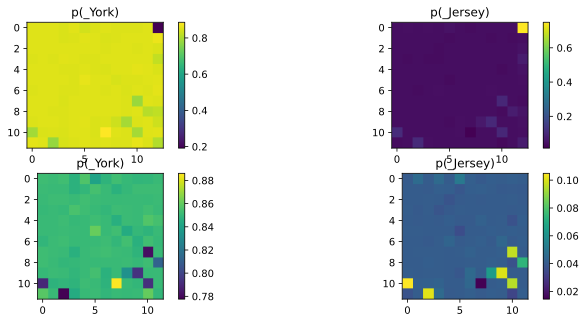

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

# Create a 2D numpy array
arr = np.zeros((12, 13))
arr2 = np.zeros((12, 13))

for (row, col), value in p_York.items():
    arr[row, col] = value
    arr2[row, col] = p_Jersey[(row, col)]

# Create the subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 5))

# Plot the heatmaps
heatmap1 = ax1.imshow(arr, cmap='viridis')
heatmap2 = ax2.imshow(arr2, cmap='viridis')
heatmap3 = ax3.imshow(arr[:, :12], cmap='viridis')
heatmap4 = ax4.imshow(arr2[:, :12], cmap='viridis')

# Add colorbars
fig.colorbar(heatmap1, ax=ax1)
fig.colorbar(heatmap2, ax=ax2)
fig.colorbar(heatmap3, ax=ax3)
fig.colorbar(heatmap4, ax=ax4)

# Set titles
ax1.set_title("p(_York)")
ax2.set_title("p(_Jersey)")
ax3.set_title("p(_York)")
ax4.set_title("p(_Jersey)")

plt.show()

We can try another sentence. How about instead of "\_Jersey" we do something less common, like "\_Japan"?

In [17]:
from tqdm import tqdm

def plot_induction_heads(model, config, inputs, position, tokens, verbose=False):
    p_York, p_Japan = {}, {}
    for layer in tqdm(range(config.n_layer)):
        for head in range(config.n_head + 1):

            # when to branch: the attn at the layer of this head
            res = None
            if head == config.n_head:
                def branch(path):
                    if path[-1] == f"f{layer}": return True
                    return False

                def which(path):
                    if f"f{layer}" in path: return 1
                    return 0
                
                res = model(inputs, which, branch).hidden_states
            else:
                def branch(path):
                    if path[-1] == f"a{layer}": return True
                    if path[-1] == f"a{layer}.head": return True
                    return False

                def which(path):
                    if f"a{layer}.head{head}" in path: return 1
                    return 0
                res = model(inputs, which, branch).hidden_states

            distrib = embed_to_distrib(model, res)[0][position]
            p_York[(layer, head)] = distrib[tokens[0]]
            p_Japan[(layer, head)] = distrib[tokens[1]]
            if verbose:
                print(f"\nLayer {layer}, Head {head}")
                # top_vals(tokenizer, distrib, n=2)

    # Create a 2D numpy array
    arr = np.zeros((12, 13))
    arr2 = np.zeros((12, 13))

    for (row, col), value in p_York.items():
        arr[row, col] = value
        arr2[row, col] = p_Japan[(row, col)]

    # Create the subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 5))

    # Plot the heatmaps
    heatmap1 = ax1.imshow(arr, cmap='viridis')
    heatmap2 = ax2.imshow(arr2, cmap='viridis')
    heatmap3 = ax3.imshow(arr[:, :12], cmap='viridis')
    heatmap4 = ax4.imshow(arr2[:, :12], cmap='viridis')

    # Add colorbars
    fig.colorbar(heatmap1, ax=ax1)
    fig.colorbar(heatmap2, ax=ax2)
    fig.colorbar(heatmap3, ax=ax3)
    fig.colorbar(heatmap4, ax=ax4)

    # Set titles
    t1, t2 = tokenizer.decode(tokens[0]).replace(" ", "_"), tokenizer.decode(tokens[1]).replace(" ", "_")
    ax1.set_title(f"p({t1})")
    ax2.set_title(f"p({t2})")
    ax3.set_title(f"p({t1})")
    ax4.set_title(f"p({t2})")

    plt.show()

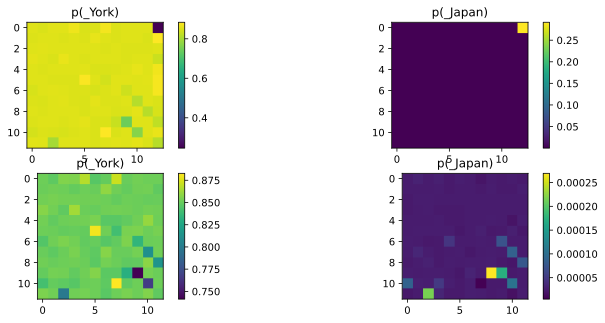

In [16]:
inputs = [
    tokenizer("I am from the state of New York. New York", return_tensors="pt"),
    tokenizer("I am from the state of New Japan. New York", return_tensors="pt")
]
position = 9
tokens = [tokenizer.encode(" York")[0], tokenizer.encode(" Japan")[0]]
plot_induction_heads(model, config, inputs, position, tokens)

Japan overall gets pretty low probability. But some of the induction heads we encountered in the previous graph also are active here, slightly nudging the probability of "\_Japan" up.

## [Title] [Name]

One interesting thing I've been meaning to look into is induction on previously seen last names after titles like "Mr." and "Mrs.". We can test that using path patching--which name does a patch affect the probabilities for?

We can see that heads 9.9, 9.6, and 10.0 (a little) are involved in name induction. Seems similar between both Mr. and Mrs. We also see heads 10.7 and 11.10 *upweighting* the name Smith when they are patched; i.e. they are anti-induction heads here.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


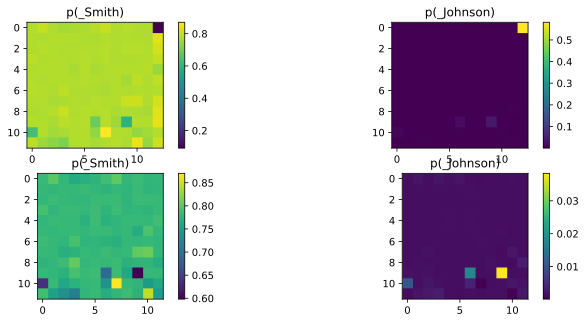

In [18]:
inputs = [
    tokenizer("A man named Tom Smith visited. Mr.", return_tensors="pt"),
    tokenizer("A man named Tom Johnson visited. Mr.", return_tensors="pt")
]
position = 8
tokens = [tokenizer.encode(" Smith")[0], tokenizer.encode(" Johnson")[0]]
plot_induction_heads(model, config, inputs, position, tokens)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.30it/s]


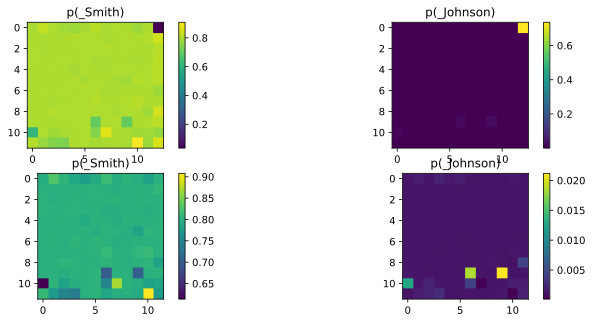

In [19]:
inputs = [
    tokenizer("A woman named Anne Smith visited. Mrs.", return_tensors="pt"),
    tokenizer("A woman named Anne Johnson visited. Mrs.", return_tensors="pt")
]
position = 8
tokens = [tokenizer.encode(" Smith")[0], tokenizer.encode(" Johnson")[0]]
plot_induction_heads(model, config, inputs, position, tokens)

## Compound path patching

We can patch two paths in the model simultaneously. Let's see what happens if we patch head 6.6 + another head, for all heads. We should get compounding effects, with greater upweighting of the probability for the second name.

In [20]:
def plot_induction_heads2(model, config, inputs, position, tokens, verbose=False):
    p_York, p_Japan = {}, {}
    for layer in tqdm(range(config.n_layer)):
        for head in range(config.n_head + 1):

            # when to branch: the attn at the layer of this head
            res = None
            if head == config.n_head:
                def branch(path):
                    if path[-1] == f"f{layer}": return True
                    if path[-1] == f"a9": return True
                    if path[-1] == f"a9.head": return True
                    return False

                def which(path):
                    if f"a9.head9" in path: return 1
                    if f"f{layer}" in path: return 1
                    return 0
                
                res = model(inputs, which, branch).hidden_states
            else:
                def branch(path):
                    if path[-1] == f"a{layer}": return True
                    if path[-1] == f"a{layer}.head": return True
                    if path[-1] == f"a9": return True
                    if path[-1] == f"a9.head": return True
                    return False

                def which(path):
                    if f"a9.head9" in path: return 1
                    if f"a{layer}.head{head}" in path: return 1
                    return 0
                res = model(inputs, which, branch).hidden_states

            distrib = embed_to_distrib(model, res)[0][position]
            p_York[(layer, head)] = distrib[tokens[0]]
            p_Japan[(layer, head)] = distrib[tokens[1]]
            if verbose:
                print(f"\nLayer {layer}, Head {head}")
                # top_vals(tokenizer, distrib, n=2)

    # Create a 2D numpy array
    arr = np.zeros((12, 13))
    arr2 = np.zeros((12, 13))

    for (row, col), value in p_York.items():
        arr[row, col] = value
        arr2[row, col] = p_Japan[(row, col)]

    # Create the subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 5))

    # Plot the heatmaps
    heatmap1 = ax1.imshow(arr, cmap='viridis')
    heatmap2 = ax2.imshow(arr2, cmap='viridis')
    heatmap3 = ax3.imshow(arr[:, :12], cmap='viridis')
    heatmap4 = ax4.imshow(arr2[:, :12], cmap='viridis')

    # Add colorbars
    fig.colorbar(heatmap1, ax=ax1)
    fig.colorbar(heatmap2, ax=ax2)
    fig.colorbar(heatmap3, ax=ax3)
    fig.colorbar(heatmap4, ax=ax4)

    # Set titles
    t1, t2 = tokenizer.decode(tokens[0]).replace(" ", "_"), tokenizer.decode(tokens[1]).replace(" ", "_")
    ax1.set_title(f"p({t1})")
    ax2.set_title(f"p({t2})")
    ax3.set_title(f"p({t1})")
    ax4.set_title(f"p({t2})")

    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.00s/it]


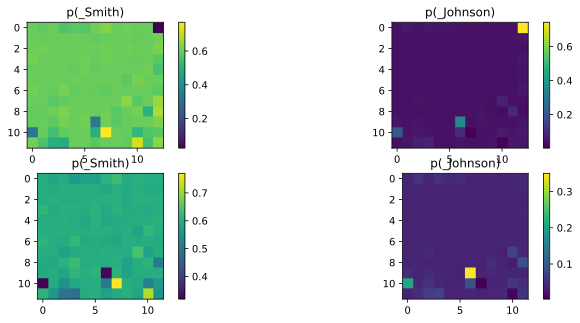

In [21]:
inputs = [
    tokenizer("A man named Tom Smith visited. Mr.", return_tensors="pt"),
    tokenizer("A man named Tom Johnson visited. Mr.", return_tensors="pt")
]
position = 8
tokens = [tokenizer.encode(" Smith")[0], tokenizer.encode(" Johnson")[0]]
plot_induction_heads2(model, config, inputs, position, tokens)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.89s/it]


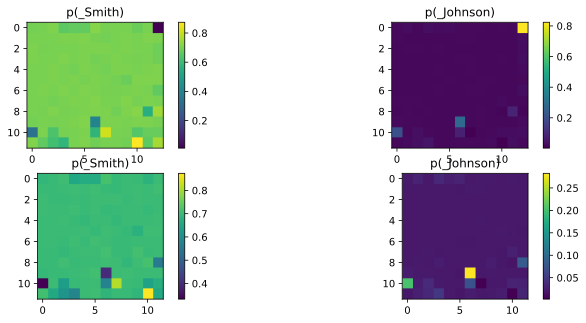

In [22]:
inputs = [
    tokenizer("A woman named Anne Smith visited. Mrs.", return_tensors="pt"),
    tokenizer("A woman named Anne Johnson visited. Mrs.", return_tensors="pt")
]
position = 8
tokens = [tokenizer.encode(" Smith")[0], tokenizer.encode(" Johnson")[0]]
plot_induction_heads2(model, config, inputs, position, tokens)